<!-- dom:TITLE: Using Neural networks to solve Ordinary Differential Equations (ODEs) -->
# Using Neural networks to solve Ordinary Differential Equations (ODEs)
<!-- dom:AUTHOR: Morten Hjorth-Jensen, MSU -->
<!-- Author: -->  
**Morten Hjorth-Jensen, MSU**

Date: **Feb 26, 2020**

## Solving eigenvalue problems as ODEs with Neural Networks

The eigenvalues and eigenvectors of a matrix A is defined by

$$
\boldsymbol{A}\boldsymbol{v} = \lambda\boldsymbol{v},
$$

where $\lambda$ is the eigenvalue and $\boldsymbol{v}$,
is the eigenvector. The problem of finding eigenvalues is important
and many physical problems can be transformed to an eigenvalue problem.

Here we use neural networks and **tensorflow** for solving an eigenvalue problem rewritten as
an ordinary differential equation.

The eigenvalue problem
is transformed into a differential equation. The equation we will use to solve the problem is

$$
\frac{dx(t)}{dt}= −x(t) + f(x(t))
$$

where $f$ is a function that contains the matrix $\boldsymbol{A}$, defined as

$$
f(\boldsymbol{x}) = [\boldsymbol{x}^T \boldsymbol{x}\boldsymbol{A} + (\boldsymbol{1} − \boldsymbol{x}^T\boldsymbol{A}\boldsymbol{x})]\boldsymbol{x}.
$$

The matrix $\boldsymbol{A}$ is a symmetric $n\times n$ matrix.

This is a non-linear differential equation. The quantity $\boldsymbol{x}$ is
one of eigenvectors with entries $\boldsymbol{x}=[x_1, x_2,\dots,x_n]^T$ and it is an output
from the neural network.

It can be shown that any stationary point of the equation
is an eigenvector of the matrix $\boldsymbol{A}$.
We can therefore disregard the time-dependency in $\boldsymbol{x}$. The
stationary state is reached when the derivative of $\boldsymbol{x}$ wrt time is zero.
This means that the problem is now simplified to solve
$\boldsymbol{x}(t)=f(\boldsymbol{x}(t))$.


The cost-function can then be set up as follows,

$$
C(\boldsymbol{x}(t)) = \mathrm{MSE}[\boldsymbol{x}(t)−f(\boldsymbol{x}(t))]=0,
$$

where $\boldsymbol{x}$ is the output of the network given some input. When the neural network trains, it will try
to minimize the difference between $\boldsymbol{x}(t)$ and $f(\boldsymbol{x}(t))$ by
tweaking the weights and biases. Starting
from any non-zero input vector, the network will converge to the eigenvector corresponding to the
largest eigenvalue.

We can also make the network converge to other eigenvectors not corresponding to the largest
eigenvalue. The easiest one to obtain is the one corresponding to the smallest eigenvalue. By using
$-\boldsymbol{A}$ instead of $\boldsymbol{A}$ in $\boldsymbol{f}$,
we will converge to the eigenvector corresponding to the smallest eigenvalue
of $\boldsymbol{A}$.
It is also possible to find the eigenvectors for the remaining eigenvalues. It can be shown
that if the input vector, lets call it $\boldsymbol{x}_0$, is orthogonal to the a set of $k$ eigenvectors, then the solution
converges to an eigenvector that is orthogonal to the $k$ eigenvectors.

Instructions for updating:
non-resource variables are not supported in the long term
A =  Tensor("Const:0", shape=(6, 6), dtype=float64)
x0 =  Tensor("Const_1:0", shape=(1, 6), dtype=float64)
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
dnn_output =  Tensor("dnn/dense_1/BiasAdd:0", shape=(1, 6), dtype=float64)
x_trial =  Tensor("loss/transpose:0", shape=(6, 1), dtype=float64)
Tensor("loss/mul:0", shape=(6, 6), dtype=float64)
Tensor("loss/mul_1:0", shape=(6, 6), dtype=float64)
Tensor("loss/Tensordot_3:0", shape=(6, 1), dtype=float64)
Step: 0 / 10000 loss:  0.7512613
Step: 100 / 10000 loss:  0.03421964
Step: 200 / 10000 loss:  0.010820755
Step: 300 / 10000 loss:  0.005255675
Step: 400 / 10000 loss:  0.0031936972
Step: 500 / 10000 loss:  0.002185765
Step: 600 / 10000 loss:  0.0015924795
Step: 700 / 10000 loss:  0.0011995457
Step: 800 / 10000 loss:  0.0009199327
Step: 900 / 10000 loss:  0.0007123702
Step: 

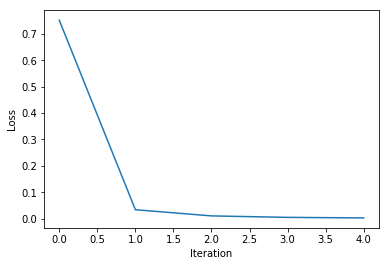

In [1]:
%matplotlib inline

# # Finding eigenvalues of matrices with neural networks. 
# Script for finding the eigenvectors corresponding to the largest eigenvalue of a matrix with a neural network.

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.reset_default_graph()
# tf.set_random_seed(343)

# import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
#from lib import compute_dx_dt

matrix_size = 6

A = np.random.random_sample(size=(matrix_size,matrix_size))
A = (A.T + A)/2.0
start_matrix = A

eigen_vals, eigen_vecs =  np.linalg.eig(A)

A = tf.convert_to_tensor(A)
print("A = ", A)

x_0 = tf.convert_to_tensor(np.random.random_sample(size = (1,matrix_size)))
print("x0 = ", x_0)

## The construction phase

num_iter = 10000
num_hidden_neurons = [50]
num_hidden_layers = np.size(num_hidden_neurons)


with tf.variable_scope('dnn'):

    previous_layer = x_0

    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer

    dnn_output = tf.layers.dense(previous_layer, matrix_size)

with tf.name_scope('loss'):
    print("dnn_output = ", dnn_output)
    
    x_trial = tf.transpose(dnn_output)
    print("x_trial = ", x_trial)
    
    temp1 = (tf.tensordot(tf.transpose(x_trial), x_trial, axes=1)*A)
    temp2 = (1- tf.tensordot(tf.transpose(x_trial), tf.tensordot(A, x_trial, axes=1), axes=1))*np.eye(matrix_size)
    func = tf.tensordot((temp1-temp2), x_trial, axes=1)
    
    print(temp1)
    print(temp2)
    print(func)
    
    func = tf.transpose(func)
    x_trial = tf.transpose(x_trial)
    
    loss = tf.losses.mean_squared_error(func, x_trial)

learning_rate = 0.001

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    traning_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

g_dnn = None

losses = []

with tf.Session() as sess:
    init.run()
    for i in range(num_iter):
        sess.run(traning_op)

        if i % 100 == 0:
            l = loss.eval()
            print("Step:", i, "/",num_iter, "loss: ", l)
            losses.append(l)

    x_dnn = x_trial.eval()
x_dnn = x_dnn.T


# ## Plotting loss over time

plt.plot(losses[:5])
plt.xlabel("Iteration")
plt.ylabel("Loss")

print("Eigenvector NN = \n", (x_dnn/(x_dnn**2).sum()**0.5), "\n")

eigen_val_nn = x_dnn.T @ (start_matrix @ x_dnn) / (x_dnn.T @ x_dnn)

print("Eigenvalue NN = \n", eigen_val_nn, "\n \n")
print("Eigenvector analytic = \n", eigen_vecs)
print("\n")
print("Eigenvalues analytic = \n",eigen_vals)